# Variability due to dynamical or property change?

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines

1. [Functions](##-Functions)
2. [Upwelling](##-Upwelling)
3. [Downwelling](##-Downwelling)
4. [Test with observations](##-Test-with-Observations)

## Functions

In [2]:
def decomp(data,base):
    d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
        'saltP':np.zeros(8),'saltQ':np.zeros(8),'saltSUM':np.zeros(8),
        'tempP':np.zeros(8),'tempQ':np.zeros(8),'tempSUM':np.zeros(8),
        'DOP':np.zeros(8),'DOQ':np.zeros(8),'DOSUM':np.zeros(8),
        'TAP':np.zeros(8),'TAQ':np.zeros(8),'TASUM':np.zeros(8),
        'NO3P':np.zeros(8),'NO3Q':np.zeros(8),'NO3SUM':np.zeros(8),
        'DICP':np.zeros(8),'DICQ':np.zeros(8),'DICSUM':np.zeros(8)}
    df = pd.DataFrame(d)

    # salt
    df['saltP'] = (data.salt[1:] - base.salt[1:])*(data.transport[1:]/data.transport[0])
    df['saltQ'] = ((data.transport[1:]/data.transport[0]) - (base.transport[1:]/base.transport[0]))*data.salt[1:]
    df['saltSUM'] = df.saltP + df.saltQ

    # temp
    df['tempP'] = (data.temp[1:] - base.temp[1:])*(data.transport[1:]/data.transport[0])
    df['tempQ'] = ((data.transport[1:]/data.transport[0]) - (base.transport[1:]/base.transport[0]))*data.temp[1:]
    df['tempSUM'] = df.tempP + df.tempQ

    # do
    df['DOP'] = (data.DO[1:] - base.DO[1:])*(data.transport[1:]/data.transport[0])
    df['DOQ'] = ((data.transport[1:]/data.transport[0]) - (base.transport[1:]/base.transport[0]))*data.DO[1:]
    df['DOSUM'] = df.DOP + df.DOQ

    # ta
    df['TAP'] = (data.TA[1:] - base.TA[1:])*(data.transport[1:]/data.transport[0])
    df['TAQ'] = ((data.transport[1:]/data.transport[0]) - (base.transport[1:]/base.transport[0]))*data.TA[1:]
    df['TASUM'] = df.TAP + df.TAQ

    # dic
    df['DICP'] = (data.DIC[1:] - base.DIC[1:])*(data.transport[1:]/data.transport[0])
    df['DICQ'] = ((data.transport[1:]/data.transport[0]) - (base.transport[1:]/base.transport[0]))*data.DIC[1:]
    df['DICSUM'] = df.DICP + df.DICQ

    # no3
    df['NO3P'] = (data.NO3[1:] - base.NO3[1:])*(data.transport[1:]/data.transport[0])
    df['NO3Q'] = ((data.transport[1:]/data.transport[0]) - (base.transport[1:]/base.transport[0]))*data.NO3[1:]
    df['NO3SUM'] = df.NO3P + df.NO3Q

    return df

def stacked_bar(df, property):
    # Calculate absolute values
    df['absP'] = df[df.columns[2]].abs()
    df['absQ'] = df[df.columns[3]].abs()

    # Normalize the data within each year
    df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
    df['normP'] = df['absP'] / df['total_abs']
    df['normQ'] = df['absQ'] / df['total_abs']

    # Aggregate normalized values by year and section
    agg_df = df.groupby(['year', 'section'])[['normP', 'normQ']].sum().reset_index()

    # Pivot the DataFrame for plotting
    pivotP = agg_df.pivot(index='year', columns='section', values='normP').fillna(0)
    pivotQ = agg_df.pivot(index='year', columns='section', values='normQ').fillna(0)

    # Plotting
    fig = plt.figure(constrained_layout=True, figsize=[8,6])
    gs = GridSpec(1, 5, figure=fig)
    ax = fig.add_subplot(gs[0, :4])
    ax2 = fig.add_subplot(gs[0, 4])

    # Assign colors to each section
    # pivot tables come out in order cuc -> fresh -> north -> off_d -> off_s -> south
    colors = ['midnightblue','magenta', 'mediumspringgreen','darkviolet','deepskyblue','red']

    # Plot normalized saltP values (left side)
    left_cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(pivotP.columns):
        bars = ax.barh(pivotP.index, -pivotP[section], left=-left_cum_values, color=colors[i % len(colors)], label=section)
        left_cum_values += pivotP[section]

    # Plot normalized saltQ values (right side)
    right_cum_values = np.zeros(len(pivotQ))
    for i, section in enumerate(pivotQ.columns):
        bars = ax.barh(pivotQ.index, pivotQ[section], left=right_cum_values, color=colors[i % len(colors)])
        right_cum_values += pivotQ[section]

    # Customize plot
    ax.axvline(0, color='grey', linewidth=2)
    # ax.set_xlabel('Normalized Absolute Values')
    title = property
    ax.set_title(title)
    # ax.set_xlim(-0.1,1.1)
    ax.set_xticks([-1,-0.5,0,0.5,1])
    ax.set_xlim([-1,1])
    ax.invert_yaxis()
    ax.set_yticks(list(set(df.year)))
    ax2.sharey(ax)

    ax.set_yticklabels(list(set(df.year)))
    # ax2.set_yticklabels([])

    plt.tight_layout()

    return ax2

def means_combo(UPs_t, UPdo_no3, UPta_dic,DWs_t, DWdo_no3, DWta_dic,):
    # make dictionary of mean transport and tracer concentrations of each WM and of JdF inflow

    # set up dictionary
    # for each variable, saved in the order total -> loop -> fresh -> south -> cuc -> off_d -> off_s -> north
    d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
        'transport':np.zeros(8),'salt':np.zeros(8),'temp':np.zeros(8),
         'DO':np.zeros(8),'NO3':np.zeros(8),'TA':np.zeros(8),'DIC':np.zeros(8)}
    df = pd.DataFrame(d)

    # hours over which data was integrated
    start = 2401
    UPlength =(np.max(UPs_t.init_t)-start+1) 
    DWlength =(np.max(DWs_t.init_t)-start+1) 

    # boundary definitions
    bdy_loo = 0
    bdy_sou = 2
    bdy_off = 3
    bdy_nor = 4

    saltdiv = 32
    sdiv = 33.5

    
    # total
    up = UPs_t
    dw = DWs_t
    upbool = ((abs(up.init_t-up.final_t) > 24) & ~np.isnan(up.final_section)) # total.. but not including tidal pumping or lost particles
    dwbool = ((abs(dw.init_t-dw.final_t) > 24) & ~np.isnan(dw.final_section))
    transport = np.append(up.init_transp[upbool].values, dw.init_transp[dwbool].values)
    df.loc[0,'transport'] = np.sum(transport)/(UPlength+DWlength)
    df.loc[0,'salt'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[0,'temp'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPdo_no3
    dw = DWdo_no3
    df.loc[0,'NO3'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[0,'DO'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPta_dic
    dw = DWta_dic
    df.loc[0,'DIC'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[0,'TA'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)

    # loop
    up = UPs_t
    dw = DWs_t
    upbool = (up.final_section==bdy_loo) & (abs(up.init_t-up.final_t) > 24)
    dwbool = (dw.final_section==bdy_loo) & (abs(dw.init_t-dw.final_t) > 24)
    transport = np.append(up.init_transp[upbool].values, dw.init_transp[dwbool].values)
    df.loc[7,'transport'] = np.sum(transport)/(UPlength+DWlength)
    df.loc[7,'salt'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[7,'temp'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPdo_no3
    dw = DWdo_no3
    df.loc[7,'NO3'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[7,'DO'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPta_dic
    dw = DWta_dic
    df.loc[7,'DIC'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[7,'TA'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)

    # fresh
    up = UPs_t
    dw = DWs_t
    upbool = ((up.final_section==bdy_sou) & (up.final_salt < saltdiv))
    dwbool = ((dw.final_section==bdy_sou) & (dw.final_salt < saltdiv))
    transport = np.append(up.init_transp[upbool].values, dw.init_transp[dwbool].values)
    df.loc[6,'transport'] = np.sum(transport)/(UPlength+DWlength)
    df.loc[6,'salt'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[6,'temp'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPdo_no3
    dw = DWdo_no3
    df.loc[6,'NO3'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[6,'DO'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPta_dic
    dw = DWta_dic
    df.loc[6,'DIC'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[6,'TA'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)

    # south
    up = UPs_t
    dw = DWs_t
    upbool = (up.final_section==bdy_sou) & (up.final_salt >= saltdiv) & (up.final_salt < sdiv)
    dwbool = (dw.final_section==bdy_sou) & (dw.final_salt >= saltdiv) & (dw.final_salt < sdiv)
    transport = np.append(up.init_transp[upbool].values, dw.init_transp[dwbool].values)
    df.loc[5,'transport'] = np.sum(transport)/(UPlength+DWlength)
    df.loc[5,'salt'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[5,'temp'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPdo_no3
    dw = DWdo_no3
    df.loc[5,'NO3'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[5,'DO'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPta_dic
    dw = DWta_dic
    df.loc[5,'DIC'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[5,'TA'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)

    # cuc
    up = UPs_t
    dw = DWs_t
    upbool = (up.final_section==bdy_sou) & (up.final_salt >= sdiv)
    dwbool = (dw.final_section==bdy_sou) & (dw.final_salt >= sdiv)
    transport = np.append(up.init_transp[upbool].values, dw.init_transp[dwbool].values)
    df.loc[1,'transport'] = np.sum(transport)/(UPlength+DWlength)
    df.loc[1,'salt'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[1,'temp'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPdo_no3
    dw = DWdo_no3
    df.loc[1,'NO3'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[1,'DO'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPta_dic
    dw = DWta_dic
    df.loc[1,'DIC'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[1,'TA'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)

    # off_d
    up = UPs_t
    dw = DWs_t
    upbool = (up.final_section==bdy_off) & (up.final_depth > 120)
    dwbool = (dw.final_section==bdy_off) & (dw.final_depth > 120)
    transport = np.append(up.init_transp[upbool].values, dw.init_transp[dwbool].values)
    df.loc[2,'transport'] = np.sum(transport)/(UPlength+DWlength)
    df.loc[2,'salt'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[2,'temp'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPdo_no3
    dw = DWdo_no3
    df.loc[2,'NO3'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[2,'DO'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPta_dic
    dw = DWta_dic
    df.loc[2,'DIC'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[2,'TA'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)

    # off_s
    up = UPs_t
    dw = DWs_t
    upbool = (up.final_section==bdy_off) & (up.final_depth <=120)
    dwbool = (dw.final_section==bdy_off) & (dw.final_depth <=120)
    transport = np.append(up.init_transp[upbool].values, dw.init_transp[dwbool].values)
    df.loc[3,'transport'] = np.sum(transport)/(UPlength+DWlength)
    df.loc[3,'salt'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[3,'temp'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPdo_no3
    dw = DWdo_no3
    df.loc[3,'NO3'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[3,'DO'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPta_dic
    dw = DWta_dic
    df.loc[3,'DIC'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[3,'TA'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)

    # north
    up = UPs_t
    dw = DWs_t
    upbool = (up.final_section==bdy_nor)
    dwbool = (dw.final_section==bdy_nor)
    transport = np.append(up.init_transp[upbool].values, dw.init_transp[dwbool].values)
    df.loc[4,'transport'] = np.sum(transport)/(UPlength+DWlength)
    df.loc[4,'salt'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[4,'temp'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPdo_no3
    dw = DWdo_no3
    df.loc[4,'NO3'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[4,'DO'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)
    up = UPta_dic
    dw = DWta_dic
    df.loc[4,'DIC'] = np.average(np.append(up.init_salt[upbool],dw.init_salt[dwbool]), weights = transport)
    df.loc[4,'TA'] = np.average(np.append(up.init_temp[upbool],dw.init_temp[dwbool]), weights = transport)

    return df

def combined_stacked_bar(df, property, ax, ax2):
    # Calculate absolute values
    df['absP'] = df[df.columns[2]].abs()
    df['absQ'] = df[df.columns[3]].abs()

    # Normalize the data within each year
    df['total_abs'] = df.groupby('year')[['absP', 'absQ']].transform('sum').sum(axis=1)
    df['normP'] = df['absP'] / df['total_abs']
    df['normQ'] = df['absQ'] / df['total_abs']

    # Aggregate normalized values by year and section
    agg_df = df.groupby(['year', 'section'])[['normP', 'normQ']].sum().reset_index()

    # Pivot the DataFrame for plotting
    pivotP = agg_df.pivot(index='year', columns='section', values='normP').fillna(0)
    pivotQ = agg_df.pivot(index='year', columns='section', values='normQ').fillna(0)

    # Assign colors to each section
    # pivot tables come out in order cuc -> fresh -> north -> off_d -> off_s -> south
    colors = ['midnightblue','magenta', 'mediumspringgreen','darkviolet','deepskyblue','red']

    # Plot normalized saltP values (left side)
    left_cum_values = np.zeros(len(pivotP))
    for i, section in enumerate(pivotP.columns):
        bars = ax.barh(pivotP.index, -pivotP[section], left=-left_cum_values, color=colors[i % len(colors)], label=section)
        left_cum_values += pivotP[section]

    # Plot normalized saltQ values (right side)
    right_cum_values = np.zeros(len(pivotQ))
    for i, section in enumerate(pivotQ.columns):
        bars = ax.barh(pivotQ.index, pivotQ[section], left=right_cum_values, color=colors[i % len(colors)])
        right_cum_values += pivotQ[section]

    # Customize plot
    ax.axvline(0, color='grey', linewidth=2)
    # ax.set_xlabel('Normalized Absolute Values')
    title = property
    ax.set_title(title)
    ax.set_xlim([-1,1])
    ax.set_xticks([-1,-0.5,0,0.5,1])
    ax.set_xticklabels([])
    ax.invert_yaxis()
    ax.set_yticks(list(set(df.year)))
    ax2.sharey(ax)

    # Ensure both axes share the same y-axis
    ax2.sharey(ax)
    # Hide y-tick labels on ax2
    ax2.tick_params(axis='y', which='both', labelleft=False)

    plt.tight_layout()
    

## Upwelling

In [3]:
up13 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2013.csv')
up14 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2014.csv')
up15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2015.csv')
up16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2016.csv')
up17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2017.csv')
up18 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2018.csv')
up21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2021.csv')
up22 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/up_2022.csv')

In [4]:
lup = [219, 161, 144, 158, 156,128,189, 117] 
# number of days in each upwelling period

In [5]:
# make 'baseline' dataframe based on the means of all the data
d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
     'transport':np.mean([up13.transport*lup[0],up14.transport*lup[1],up15.transport*lup[2],up16.transport*lup[3],up17.transport*lup[4],up18.transport*lup[5],up21.transport*lup[-2],up22.transport*lup[-1]],axis=0),
     'salt':np.mean([up13.salt,up14.salt,up15.salt,up16.salt,up17.salt,up18.salt,up21.salt,up22.salt],axis=0),
     'temp':np.mean([up13.temp,up14.temp,up15.temp,up16.temp,up17.temp,up18.temp,up21.temp,up22.temp],axis=0),
     'DO':np.mean([up13.DO,up14.DO,up15.DO,up16.DO,up17.DO,up18.DO,up21.DO,up22.DO],axis=0),
     'NO3':np.mean([up13.NO3,up14.NO3,up15.NO3,up16.NO3,up17.NO3,up18.NO3,up21.NO3,up22.NO3],axis=0),
     'TA':np.mean([up13.TA,up14.TA,up15.TA,up16.TA,up17.TA,up18.TA,up21.TA,up22.TA],axis=0),
     'DIC':np.mean([up13.DIC,up14.DIC,up15.DIC,up16.DIC,up17.DIC,up18.DIC,up21.DIC,up22.DIC],axis=0)}
up_b = pd.DataFrame(d)

up_b

,section,transport,salt,temp,DO,NO3,TA,DIC
0,salish,2.863975e+07,33.459940,7.037808,88.451151,32.362760,2298.322521,2291.786148
1,cuc,6.988961e+06,33.903709,6.202813,64.173482,37.071861,2325.509649,2324.233987
2,off_d,6.301985e+06,33.748754,6.580460,91.096080,33.497816,2313.637604,2295.119165
3,off_s,1.261685e+06,32.877001,8.434065,215.076405,16.431206,2269.053222,2158.198328
4,north,5.615433e+06,33.236996,7.552276,152.598064,24.212471,2285.811509,2223.733701
5,south,1.054138e+06,32.966089,8.870049,197.482199,19.308755,2274.857436,2179.931986
6,fresh,3.024060e+05,29.472819,10.660579,305.963425,5.255242,2139.329199,1950.328518
7,loop,7.115140e+06,32.028574,8.808087,160.653640,28.007107,2231.485357,2189.946470


In [10]:
up13.transport = up13.transport*lup[0]
up14.transport = up14.transport*lup[1]
up15.transport = up15.transport*lup[2]
up16.transport = up16.transport*lup[3]
up17.transport = up17.transport*lup[4]
up18.transport = up18.transport*lup[5]
# up19.transport = up19.transport*lup[0]
# up20.transport = up20.transport*lup[0]
up21.transport = up21.transport*lup[-2]
up22.transport = up22.transport*lup[-1]
# up23.transport = up23.transport*lup[0]


In [11]:
# math!
math_up13 = decomp(up13,up_b)[1:]
math_up14 = decomp(up14,up_b)[1:]
math_up15 = decomp(up15,up_b)[1:]
math_up16 = decomp(up16,up_b)[1:]
math_up17 = decomp(up17,up_b)[1:]
math_up18 = decomp(up18,up_b)[1:]
# math_up19 = decomp(up19,up_b)[1:]
# math_up20 = decomp(up20,up_b)[1:]
math_up21 = decomp(up21,up_b)[1:]
math_up22 = decomp(up22,up_b)[1:]

# add year 
math_up13['year'] = 2013
math_up14['year'] = 2014
math_up15['year'] = 2015
math_up16['year'] = 2016
math_up17['year'] = 2017
math_up18['year'] = 2018
# math_up19['year'] = 2019
# math_up20['year'] = 2020
math_up21['year'] = 2021
math_up22['year'] = 2022

/tmp/ipykernel_141891/2312449115.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'Salinity (g/kg)')

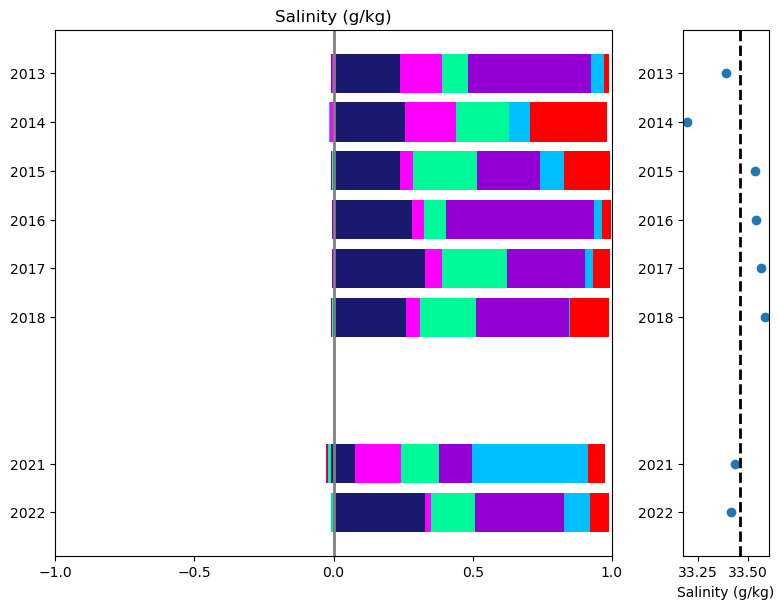

In [12]:
df = pd.concat([math_up13[['year','section','saltP','saltQ']][:-1],math_up14[['year','section','saltP','saltQ']][:-1],
    math_up15[['year','section','saltP','saltQ']][:-1],math_up16[['year','section','saltP','saltQ']][:-1],
    math_up17[['year','section','saltP','saltQ']][:-1],math_up18[['year','section','saltP','saltQ']][:-1],
    math_up21[['year','section','saltP','saltQ']][:-1],math_up22[['year','section','saltP','saltQ']][:-1]])
ax2 = stacked_bar(df,'Salinity (g/kg)')

# mean property inflow to JdF
ax2.scatter([up13.salt[0],up14.salt[0],up15.salt[0],up16.salt[0],up17.salt[0],up18.salt[0],up21.salt[0],up22.salt[0]],
            [2013,2014,2015,2016,2017,2018,2021,2022])
ax2.axvline(up_b.salt[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('Salinity (g/kg)')
# ax2.set_xlim([33.4,33.45])
# ax2.set_xticks([33.41,33.44])


/tmp/ipykernel_141891/2312449115.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'Temperature ($^\\circ C$)')

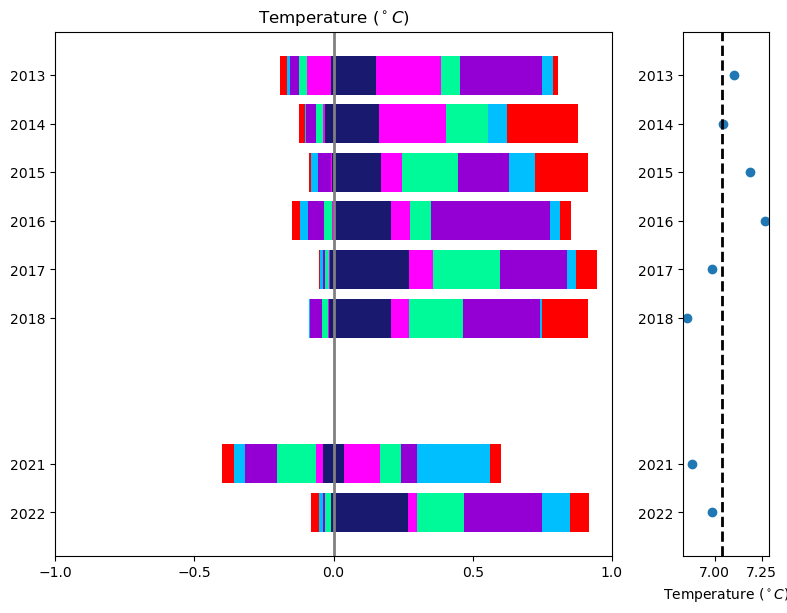

In [13]:
df = pd.concat([math_up13[['year','section','tempP','tempQ']][:-1],math_up14[['year','section','tempP','tempQ']][:-1],
    math_up15[['year','section','tempP','tempQ']][:-1],math_up16[['year','section','tempP','tempQ']][:-1],
    math_up17[['year','section','tempP','tempQ']][:-1],math_up18[['year','section','tempP','tempQ']][:-1],
    math_up21[['year','section','tempP','tempQ']][:-1],math_up22[['year','section','tempP','tempQ']][:-1]])
ax2 = stacked_bar(df,'Temperature ($^\circ C$)')

# mean property inflow to JdF
ax2.scatter([up13.temp[0],up14.temp[0],up15.temp[0],up16.temp[0],up17.temp[0],up18.temp[0],up21.temp[0],up22.temp[0]], 
            [2013,2014,2015,2016,2017,2018,2021,2022])
ax2.axvline(up_b.temp[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('Temperature ($^\circ C$)')
# ax2.set_xlim([33.4,33.45])
# ax2.set_xticks([33.41,33.44])

/tmp/ipykernel_141891/2312449115.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'DO ()')

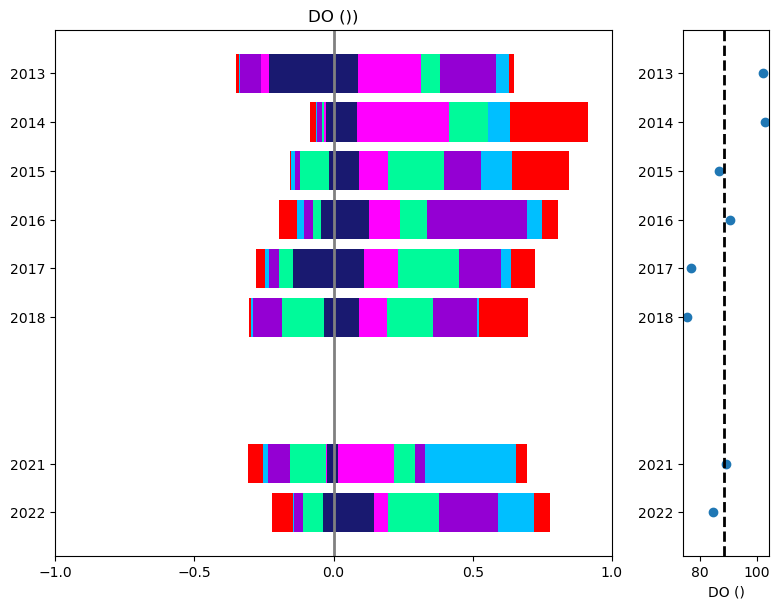

In [15]:
df = pd.concat([math_up13[['year','section','DOP','DOQ']][:-1],math_up14[['year','section','DOP','DOQ']][:-1],
    math_up15[['year','section','DOP','DOQ']][:-1],math_up16[['year','section','DOP','DOQ']][:-1],
    math_up17[['year','section','DOP','DOQ']][:-1],math_up18[['year','section','DOP','DOQ']][:-1],
    math_up21[['year','section','DOP','DOQ']][:-1],math_up22[['year','section','DOP','DOQ']][:-1]])
ax2 = stacked_bar(df,'DO ())')

# mean property inflow to JdF
ax2.scatter([up13.DO[0],up14.DO[0],up15.DO[0],up16.DO[0],up17.DO[0],up18.DO[0],up21.DO[0],up22.DO[0]], 
            [2013,2014,2015,2016,2017,2018,2021,2022])
ax2.axvline(up_b.DO[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('DO ()')
# ax2.set_xlim([33.4,33.45])
# ax2.set_xticks([33.41,33.44])

/tmp/ipykernel_141891/2312449115.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'NO3 ()')

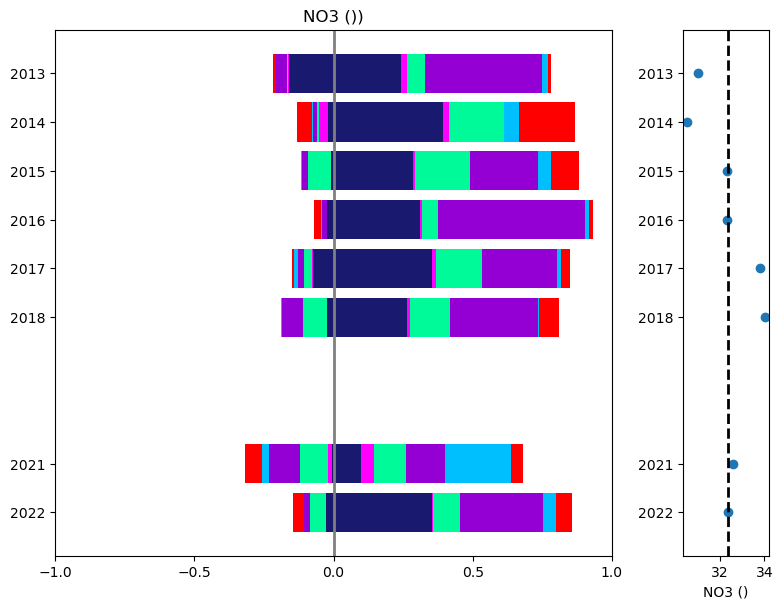

In [16]:
df = pd.concat([math_up13[['year','section','NO3P','NO3Q']][:-1],math_up14[['year','section','NO3P','NO3Q']][:-1],
    math_up15[['year','section','NO3P','NO3Q']][:-1],math_up16[['year','section','NO3P','NO3Q']][:-1],
    math_up17[['year','section','NO3P','NO3Q']][:-1],math_up18[['year','section','NO3P','NO3Q']][:-1],
    math_up21[['year','section','NO3P','NO3Q']][:-1],math_up22[['year','section','NO3P','NO3Q']][:-1]])
ax2 = stacked_bar(df,'NO3 ())')

# mean property inflow to JdF
ax2.scatter([up13.NO3[0],up14.NO3[0],up15.NO3[0],up16.NO3[0],up17.NO3[0],up18.NO3[0],up21.NO3[0],up22.NO3[0]], 
            [2013,2014,2015,2016,2017,2018,2021,2022])
ax2.axvline(up_b.NO3[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('NO3 ()')
# ax2.set_xlim([33.4,33.45])
# ax2.set_xticks([33.41,33.44])

/tmp/ipykernel_141891/2312449115.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'TA ()')

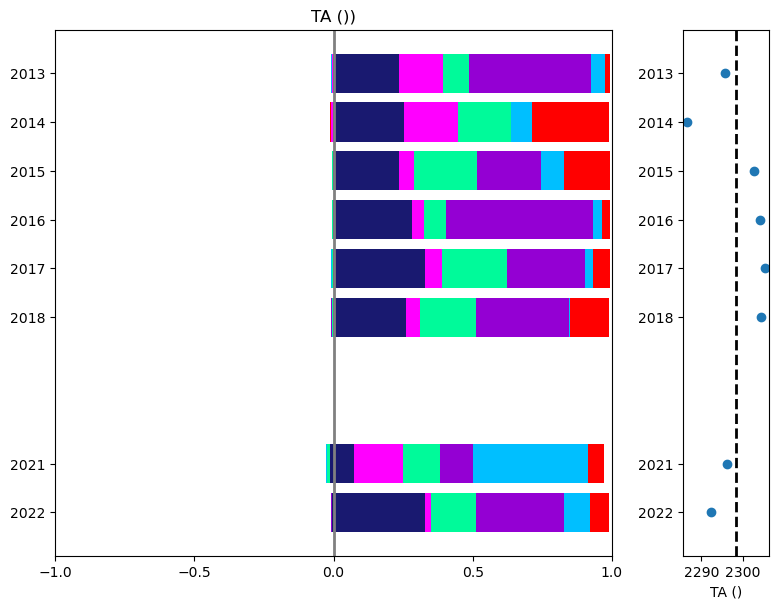

In [17]:
df = pd.concat([math_up13[['year','section','TAP','TAQ']][:-1],math_up14[['year','section','TAP','TAQ']][:-1],
    math_up15[['year','section','TAP','TAQ']][:-1],math_up16[['year','section','TAP','TAQ']][:-1],
    math_up17[['year','section','TAP','TAQ']][:-1],math_up18[['year','section','TAP','TAQ']][:-1],
    math_up21[['year','section','TAP','TAQ']][:-1],math_up22[['year','section','TAP','TAQ']][:-1]])
ax2 = stacked_bar(df,'TA ())')

# mean property inflow to JdF
ax2.scatter([up13.TA[0],up14.TA[0],up15.TA[0],up16.TA[0],up17.TA[0],up18.TA[0],up21.TA[0],up22.TA[0]], 
            [2013,2014,2015,2016,2017,2018,2021,2022])
ax2.axvline(up_b.TA[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('TA ()')
# ax2.set_xlim([33.4,33.45])
# ax2.set_xticks([33.41,33.44])

/tmp/ipykernel_141891/2312449115.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'DIC ()')

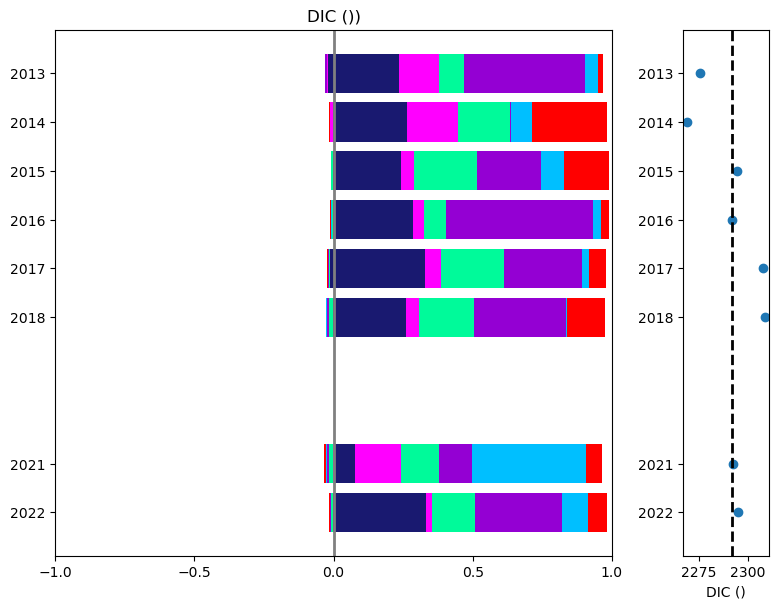

In [18]:
df = pd.concat([math_up13[['year','section','DICP','DICQ']][:-1],math_up14[['year','section','DICP','DICQ']][:-1],
    math_up15[['year','section','DICP','DICQ']][:-1],math_up16[['year','section','DICP','DICQ']][:-1],
    math_up17[['year','section','DICP','DICQ']][:-1],math_up18[['year','section','DICP','DICQ']][:-1],
    math_up21[['year','section','DICP','DICQ']][:-1],math_up22[['year','section','DICP','DICQ']][:-1]])
ax2 = stacked_bar(df,'DIC ())')

# mean property inflow to JdF
ax2.scatter([up13.DIC[0],up14.DIC[0],up15.DIC[0],up16.DIC[0],up17.DIC[0],up18.DIC[0],up21.DIC[0],up22.DIC[0]], 
            [2013,2014,2015,2016,2017,2018,2021,2022])
ax2.axvline(up_b.DIC[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('DIC ()')
# ax2.set_xlim([33.4,33.45])
# ax2.set_xticks([33.41,33.44])

## Downwelling

In [19]:
dw13 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2014.csv')
dw15 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2016.csv')
dw16 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2017.csv')
dw17 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2018.csv')
dw20 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2021.csv')
dw21 = pd.read_csv('/data1/bbeutel/LO_user/ariane/summary_files/down_2022.csv')

In [20]:
ldw = [113, 149, 198, 91, 82, 105] 
# number of days in each downwelling period

In [21]:
# make 'baseline' dataframe based on the means of all the data
d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
     'transport':np.mean([dw13.transport*ldw[0],dw15.transport*ldw[1],dw16.transport*ldw[2],dw17.transport*ldw[3],dw20.transport*ldw[-2],dw21.transport*ldw[-1]],axis=0),
     'salt':np.mean([dw13.salt,dw15.salt,dw16.salt,dw17.salt,dw20.salt,dw21.salt],axis=0),
     'temp':np.mean([dw13.temp,dw15.temp,dw16.temp,dw17.temp,dw20.temp,dw21.temp],axis=0),
     'DO':np.mean([dw13.DO,dw15.DO,dw16.DO,dw17.DO,dw20.DO,dw21.DO],axis=0),
     'NO3':np.mean([dw13.NO3,dw15.NO3,dw16.NO3,dw17.NO3,dw20.NO3,dw21.NO3],axis=0),
     'TA':np.mean([dw13.TA,dw15.TA,dw16.TA,dw17.TA,dw20.TA,dw21.TA],axis=0),
     'DIC':np.mean([dw13.DIC,dw15.DIC,dw16.DIC,dw17.DIC,dw20.DIC,dw21.DIC],axis=0)}
dw_b = pd.DataFrame(d)

dw_b

,section,transport,salt,temp,DO,NO3,TA,DIC
0,salish,1.855720e+07,32.173399,8.410981,176.806784,23.745508,2238.425297,2175.466437
1,cuc,2.568407e+06,33.749628,6.878578,74.408100,35.189066,2311.193071,2311.714033
2,off_d,6.322183e+05,33.589503,7.056655,103.421958,31.376956,2302.172513,2279.579369
3,off_s,5.921559e+05,32.759696,9.640343,211.866269,14.230491,2263.510710,2142.802372
4,north,2.310261e+05,32.755873,9.441226,194.742690,16.578581,2262.446935,2161.315271
5,south,4.216037e+06,32.813170,9.462335,194.792455,17.734291,2267.948986,2171.190798
6,fresh,3.025393e+06,30.040163,9.924328,290.358969,8.162885,2160.199810,1993.963831
7,loop,7.291966e+06,31.803371,8.277058,186.556792,26.872000,2217.280471,2170.107308


In [22]:
dw13.transport = dw13.transport*ldw[0]
# dw14.transport = dw14.transport*ldw[0]
dw15.transport = dw15.transport*ldw[1]
dw16.transport = dw16.transport*ldw[2]
dw17.transport = dw17.transport*ldw[3]
# dw18.transport = dw18.transport*ldw[0]
# dw19.transport = dw19.transport*ldw[0]
dw20.transport = dw20.transport*ldw[4]
dw21.transport = dw21.transport*ldw[5]
# dw22.transport = dw22.transport*ldw[0]
# dw23.transport = dw23.transport*ldw[0]


In [23]:
# math! 
math_dw13 = decomp(dw13,dw_b)[1:]
math_dw15 = decomp(dw15,dw_b)[1:]
math_dw16 = decomp(dw16,dw_b)[1:]
math_dw17 = decomp(dw17,dw_b)[1:]
# math_dw18 = decomp(dw18,dw_b)[1:]
# math_dw19 = decomp(dw19,dw_b)[1:]
math_dw20 = decomp(dw20,dw_b)[1:]
math_dw21 = decomp(dw21,dw_b)[1:]

# add year 
math_dw13['year'] = 2013
math_dw15['year'] = 2015
math_dw16['year'] = 2016
math_dw17['year'] = 2017
# math_dw18['year'] = 2018
# math_dw19['year'] = 2019
math_dw20['year'] = 2020
math_dw21['year'] = 2021

/tmp/ipykernel_141891/2312449115.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'Salinity (g/kg)')

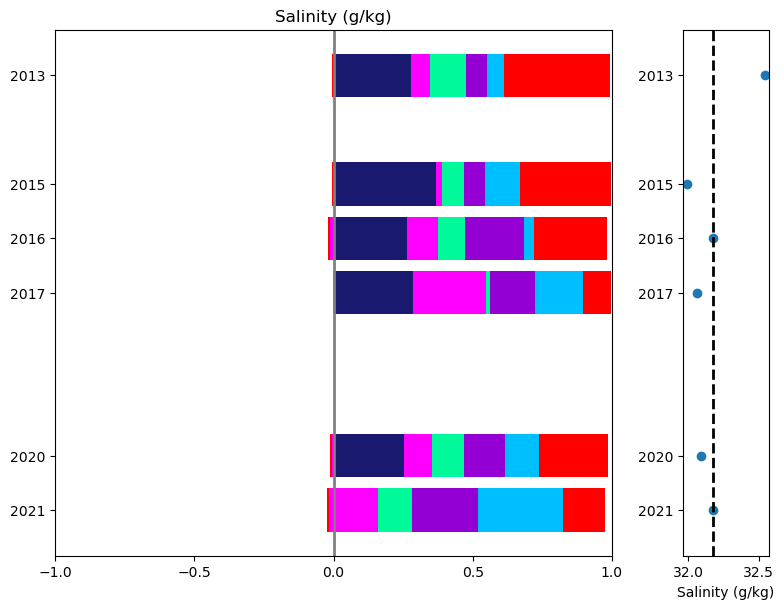

In [24]:
df = pd.concat([math_dw13[['year','section','saltP','saltQ']][:-1],
    math_dw15[['year','section','saltP','saltQ']][:-1],math_dw16[['year','section','saltP','saltQ']][:-1],
    math_dw17[['year','section','saltP','saltQ']][:-1],
    math_dw20[['year','section','saltP','saltQ']][:-1],math_dw21[['year','section','saltP','saltQ']][:-1]])
ax2 = stacked_bar(df,'Salinity (g/kg)')

# mean property inflow to JdF
ax2.scatter([dw13.salt[0],dw15.salt[0],dw16.salt[0],dw17.salt[0],dw20.salt[0],dw21.salt[0]], 
            [2013,2015,2016,2017,2020,2021])
ax2.axvline(dw_b.salt[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('Salinity (g/kg)')
# ax2.set_xlim([33.4,33.45])
# ax2.set_xticks([33.41,33.44])

/tmp/ipykernel_141891/2312449115.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'Temperature ($^\\circ C$)')

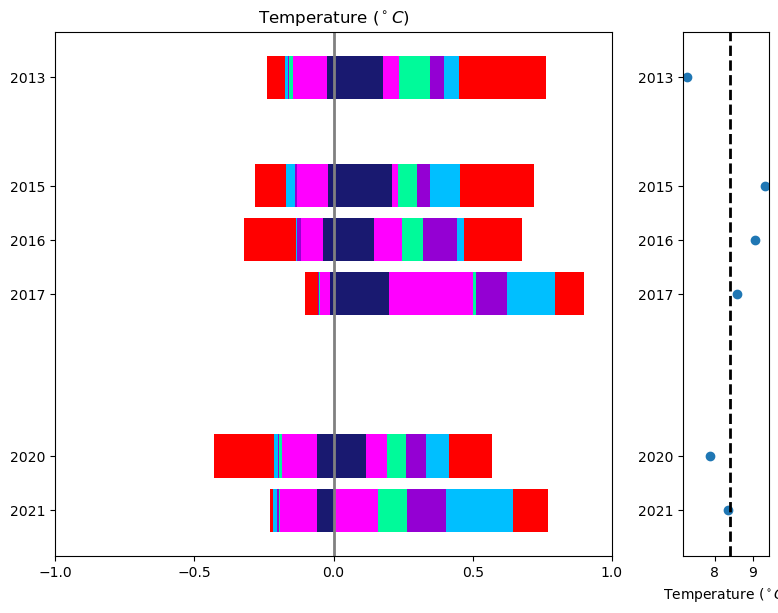

In [25]:
df = pd.concat([math_dw13[['year','section','tempP','tempQ']][:-1],
    math_dw15[['year','section','tempP','tempQ']][:-1],math_dw16[['year','section','tempP','tempQ']][:-1],
    math_dw17[['year','section','tempP','tempQ']][:-1],
    math_dw20[['year','section','tempP','tempQ']][:-1],math_dw21[['year','section','tempP','tempQ']][:-1]])
ax2 = stacked_bar(df,'Temperature ($^\circ C$)')

# mean property inflow to JdF
ax2.scatter([dw13.temp[0],dw15.temp[0],dw16.temp[0],dw17.temp[0],dw20.temp[0],dw21.temp[0]], 
            [2013,2015,2016,2017,2020,2021])
ax2.axvline(dw_b.temp[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('Temperature ($^\circ C$)')

/tmp/ipykernel_141891/2312449115.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'DO ()')

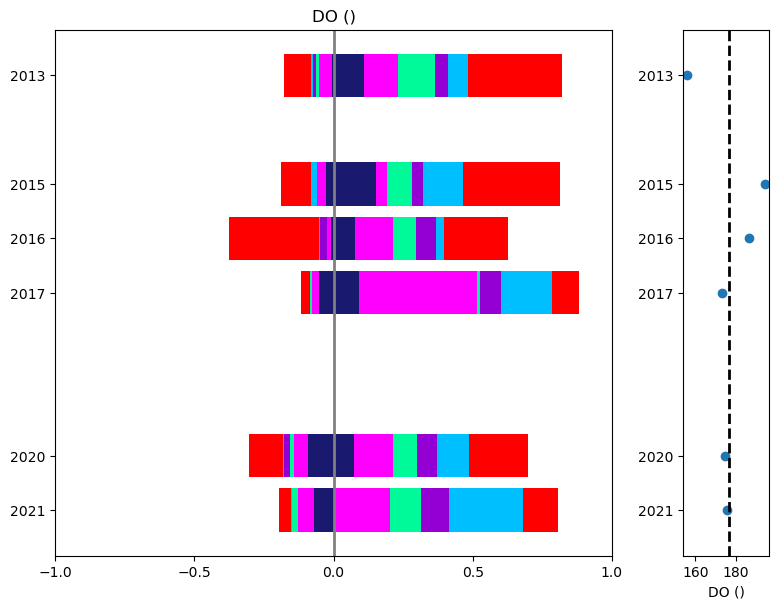

In [26]:
df = pd.concat([math_dw13[['year','section','DOP','DOQ']][:-1],
    math_dw15[['year','section','DOP','DOQ']][:-1],math_dw16[['year','section','DOP','DOQ']][:-1],
    math_dw17[['year','section','DOP','DOQ']][:-1],
    math_dw20[['year','section','DOP','DOQ']][:-1],math_dw21[['year','section','DOP','DOQ']][:-1]])
ax2 = stacked_bar(df,'DO ()')

# mean property inflow to JdF
ax2.scatter([dw13.DO[0],dw15.DO[0],dw16.DO[0],dw17.DO[0],dw20.DO[0],dw21.DO[0]], 
            [2013,2015,2016,2017,2020,2021])
ax2.axvline(dw_b.DO[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('DO ()')

/tmp/ipykernel_141891/2312449115.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'Nitrate ()')

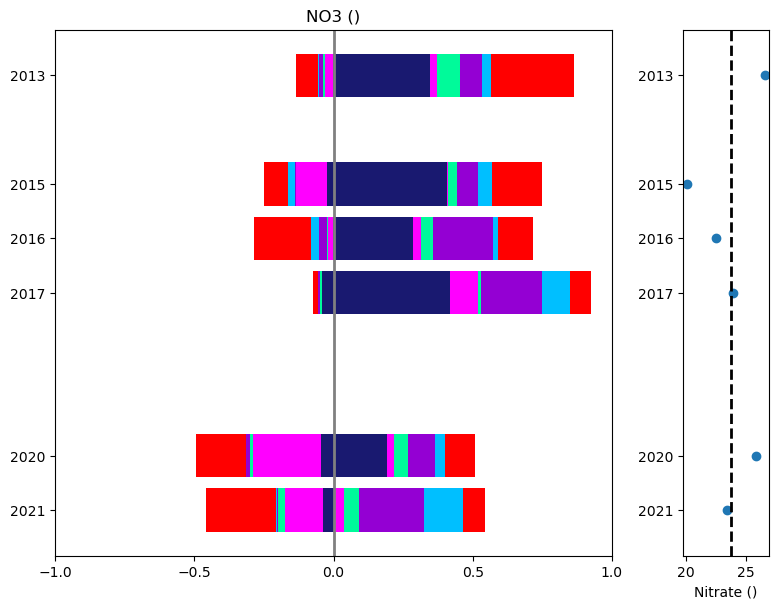

In [27]:
df = pd.concat([math_dw13[['year','section','NO3P','NO3Q']][:-1],
    math_dw15[['year','section','NO3P','NO3Q']][:-1],math_dw16[['year','section','NO3P','NO3Q']][:-1],
    math_dw17[['year','section','NO3P','NO3Q']][:-1],
    math_dw20[['year','section','NO3P','NO3Q']][:-1],math_dw21[['year','section','NO3P','NO3Q']][:-1]])
ax2 = stacked_bar(df,'NO3 ()')

# mean property inflow to JdF
ax2.scatter([dw13.NO3[0],dw15.NO3[0],dw16.NO3[0],dw17.NO3[0],dw20.NO3[0],dw21.NO3[0]], [2013,2015,2016,2017,2020,2021])
ax2.axvline(dw_b.NO3[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('Nitrate ()')

/tmp/ipykernel_141891/2312449115.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'TA ()')

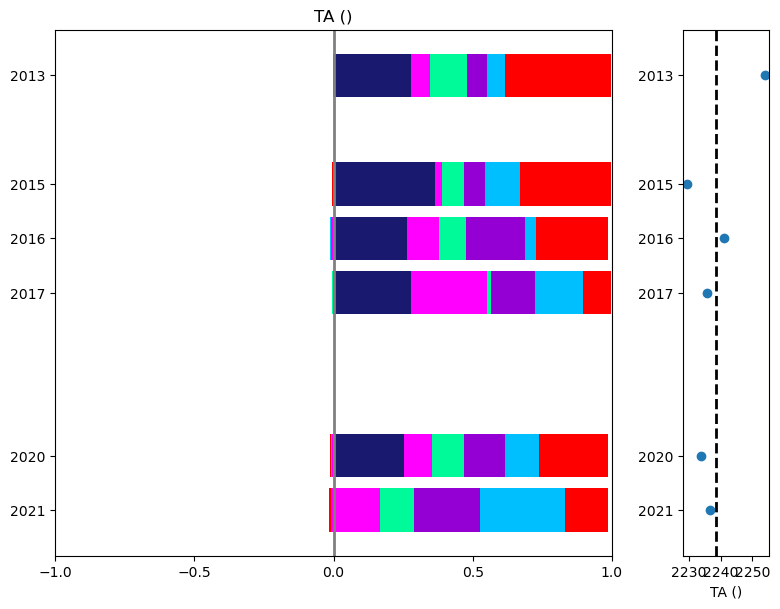

In [28]:
df = pd.concat([math_dw13[['year','section','TAP','TAQ']][:-1],
    math_dw15[['year','section','TAP','TAQ']][:-1],math_dw16[['year','section','TAP','TAQ']][:-1],
    math_dw17[['year','section','TAP','TAQ']][:-1],
    math_dw20[['year','section','TAP','TAQ']][:-1],math_dw21[['year','section','TAP','TAQ']][:-1]])
ax2 = stacked_bar(df,'TA ()')

# mean property inflow to JdF
ax2.scatter([dw13.TA[0],dw15.TA[0],dw16.TA[0],dw17.TA[0],dw20.TA[0],dw21.TA[0]], 
            [2013,2015,2016,2017,2020,2021])
ax2.axvline(dw_b.TA[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('TA ()')

/tmp/ipykernel_141891/2312449115.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


Text(0.5, 36.72222222222221, 'DIC ()')

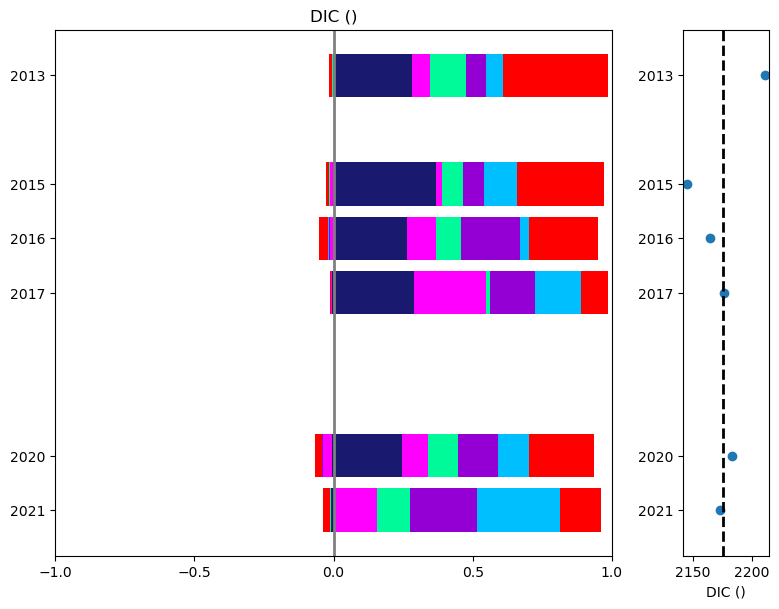

In [29]:
df = pd.concat([math_dw13[['year','section','DICP','DICQ']][:-1],
    math_dw15[['year','section','DICP','DICQ']][:-1],math_dw16[['year','section','DICP','DICQ']][:-1],
    math_dw17[['year','section','DICP','DICQ']][:-1],
    math_dw20[['year','section','DICP','DICQ']][:-1],math_dw21[['year','section','DICP','DICQ']][:-1]])
ax2 = stacked_bar(df,'DIC ()')

# mean property inflow to JdF
ax2.scatter([dw13.DIC[0],dw15.DIC[0],dw16.DIC[0],dw17.DIC[0],dw20.DIC[0],dw21.DIC[0]], 
            [2013,2015,2016,2017,2020,2021])
ax2.axvline(dw_b.DIC[0], color='k', ls='dashed', linewidth=2)
ax2.set_xlabel('DIC ()')

## All together now
combine downwelling and upwelling into one year (downwelling preceding upwelling counting as the upwelling year)

In [22]:
com14 = means_combo(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20140903/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20140903/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20140903/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20140306/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20140306/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20140306/ariane_positions_quantitative.nc'))

com16 = means_combo(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20160913/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20160913/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20160913/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20160319/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20160319/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20160319/ariane_positions_quantitative.nc'))

com17 = means_combo(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20171012/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20171012/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20171012/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20170419/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20170419/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20170419/ariane_positions_quantitative.nc'))

com18 = means_combo(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20180906/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20180906/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20180906/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20180201/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20180201/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20180201/ariane_positions_quantitative.nc'))

com21 = means_combo(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20210922/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20210922/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20210922/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20210202/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20210202/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20210202/ariane_positions_quantitative.nc'))

com22 = means_combo(xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/S_T/20221015/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/DO_NO3/20221015/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/up_cas7/TA_DIC/20221015/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/S_T/20220125/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/DO_NO3/20220125/ariane_positions_quantitative.nc'),
             xr.open_dataset('/data1/bbeutel/LO_user/ariane/down_cas7/TA_DIC/20220125/ariane_positions_quantitative.nc'))

In [ ]:
# make 'baseline' dataframe based on the means of all the data
d = {'section':['salish','cuc', 'off_d', 'off_s', 'north', 'south', 'fresh','loop'],
     'transport':np.mean([com14.transport,com16.transport,com17.transport,com18.transport,com21.transport,com22.transport],axis=0),
     'salt':np.mean([com14.salt,com16.salt,com17.salt,com18.salt,com21.salt,com22.salt],axis=0),
     'temp':np.mean([com14.temp,com16.temp,com17.temp,com18.temp,com21.temp,com22.temp],axis=0),
     'DO':np.mean([com14.DO,com16.DO,com17.DO,com18.DO,com21.DO,com22.DO],axis=0),
     'NO3':np.mean([com14.NO3,com16.NO3,com17.NO3,com18.NO3,com21.NO3,com22.NO3],axis=0),
     'TA':np.mean([com14.TA,com16.TA,com17.TA,com18.TA,com21.TA,com22.TA],axis=0),
     'DIC':np.mean([com14.DIC,com16.DIC,com17.DIC,com18.DIC,com21.DIC,com22.DIC],axis=0)}
com_b = pd.DataFrame(d)

com_b

In [24]:
# math! 
math_com14 = decomp(com14,com_b)[1:]
math_com16 = decomp(com16,com_b)[1:]
math_com17 = decomp(com17,com_b)[1:]
math_com18 = decomp(com18,com_b)[1:]
# math_com19 = decomp(com19,com_b)[1:]
# math_com20 = decomp(com20,com_b)[1:]
math_com21 = decomp(com21,com_b)[1:]
math_com22 = decomp(com22,com_b)[1:]

# add year 
math_com14['year'] = 2014
math_com16['year'] = 2016
math_com17['year'] = 2017
math_com18['year'] = 2018
# math_com19['year'] = 2019
# math_com20['year'] = 2020
math_com21['year'] = 2021
math_com22['year'] = 2022

### plotting

In [ ]:
# Plotting
fig = plt.figure(constrained_layout=True, figsize=[7,2*6])
gs = GridSpec(6, 5, figure=fig)
ax1 = fig.add_subplot(gs[0, :4])
ax2 = fig.add_subplot(gs[0, 4])
ax3 = fig.add_subplot(gs[1, :4])
ax4 = fig.add_subplot(gs[1, 4])
ax5 = fig.add_subplot(gs[2, :4])
ax6 = fig.add_subplot(gs[2, 4])
ax7 = fig.add_subplot(gs[3, :4])
ax8 = fig.add_subplot(gs[3, 4])
ax9 = fig.add_subplot(gs[4, :4])
ax10 = fig.add_subplot(gs[4, 4])
ax11 = fig.add_subplot(gs[5, :4])
ax12 = fig.add_subplot(gs[5, 4])

# SALINITY
df = pd.concat([math_com14[['year','section','saltP','saltQ']][:-1],
    math_com16[['year','section','saltP','saltQ']][:-1],math_com17[['year','section','saltP','saltQ']][1:],
    math_com18[['year','section','saltP','saltQ']][:-1],
    math_com21[['year','section','saltP','saltQ']][:-1],math_com22[['year','section','saltP','saltQ']][1:]])
combined_stacked_bar(df,'Salinity (g/kg)',ax1,ax2)

# mean property inflow to JdF
ax2.scatter([com14.salt[0],com16.salt[0],com17.salt[0],com18.salt[0],com21.salt[0],com22.salt[0]], [2014,2016,2017,2018,2021,2022],c='k')
ax2.scatter([up14.salt[0],up16.salt[0],up17.salt[0],up18.salt[0],up21.salt[0],up22.salt[0]], [2014,2016,2017,2018,2021,2022],alpha=0.6,c='tab:orange')
ax2.scatter([dw13.salt[0],dw15.salt[0],dw16.salt[0],dw17.salt[0],dw20.salt[0],dw21.salt[0]], [2014,2016,2017,2018,2021,2022],alpha=0.6,c='tab:blue')
ax2.axvline(com_b.salt[0], color='k', ls='dashed', linewidth=2)
ax2.axvline(up_b.salt[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax2.axvline(dw_b.salt[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax2.set_xlabel('Salinity (g/kg)',fontsize=10)

# TEMPERATURE
df = pd.concat([math_com14[['year','section','tempP','tempQ']][:-1],
    math_com16[['year','section','tempP','tempQ']][:-1],math_com17[['year','section','tempP','tempQ']][1:],
    math_com18[['year','section','tempP','tempQ']][:-1],
    math_com21[['year','section','tempP','tempQ']][:-1],math_com22[['year','section','tempP','tempQ']][1:]])
combined_stacked_bar(df,'Temperature (degC)',ax3,ax4)

# mean property inflow to JdF
ax4.scatter([com14.temp[0],com16.temp[0],com17.temp[0],com18.temp[0],com21.temp[0],com22.temp[0]], [2014,2016,2017,2018,2021,2022],c='k')
ax4.scatter([up14.temp[0],up16.temp[0],up17.temp[0],up18.temp[0],up21.temp[0],up22.temp[0]], [2014,2016,2017,2018,2021,2022],alpha=0.6,c='tab:orange')
ax4.scatter([dw13.temp[0],dw15.temp[0],dw16.temp[0],dw17.temp[0],dw20.temp[0],dw21.temp[0]], [2014,2016,2017,2018,2021,2022],alpha=0.6,c='tab:blue')
ax4.axvline(com_b.temp[0], color='k', ls='dashed', linewidth=2)
ax4.axvline(up_b.temp[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax4.axvline(dw_b.temp[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax4.set_xlabel('Temperature ($^\circ C$)',fontsize=10)

# DO
df = pd.concat([math_com14[['year','section','DOP','DOQ']][:-1],
    math_com16[['year','section','DOP','DOQ']][:-1],math_com17[['year','section','DOP','DOQ']][1:],
    math_com18[['year','section','DOP','DOQ']][:-1],
    math_com21[['year','section','DOP','DOQ']][:-1],math_com22[['year','section','DOP','DOQ']][1:]])
combined_stacked_bar(df,'DO (umol kg-1)',ax5,ax6)

# mean property inflow to JdF
ax6.scatter([com14.DO[0],com16.DO[0],com17.DO[0],com18.DO[0],com21.DO[0],com22.DO[0]], [2014,2016,2017,2018,2021,2022],c='k')
ax6.scatter([up14.DO[0],up16.DO[0],up17.DO[0],up18.DO[0],up21.DO[0],up22.DO[0]], [2014,2016,2017,2018,2021,2022],alpha=0.6,c='tab:orange')
ax6.scatter([dw13.DO[0],dw15.DO[0],dw16.DO[0],dw17.DO[0],dw20.DO[0],dw21.DO[0]], [2014,2016,2017,2018,2021,2022],alpha=0.6,c='tab:blue')
ax6.axvline(com_b.DO[0], color='k', ls='dashed', linewidth=2)
ax6.axvline(up_b.DO[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax6.axvline(dw_b.DO[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax6.set_xlabel('DO (umol kg-1)',fontsize=10)

# NO3
df = pd.concat([math_com14[['year','section','NO3P','NO3Q']][:-1],
    math_com16[['year','section','NO3P','NO3Q']][:-1],math_com17[['year','section','NO3P','NO3Q']][1:],
    math_com18[['year','section','NO3P','NO3Q']][:-1],
    math_com21[['year','section','NO3P','NO3Q']][:-1],math_com22[['year','section','NO3P','NO3Q']][1:]])
combined_stacked_bar(df,'NO3 (uM)',ax7,ax8)

# mean property inflow to JdF
ax8.scatter([com14.NO3[0],com16.NO3[0],com17.NO3[0],com18.NO3[0],com21.NO3[0],com22.NO3[0]], [2014,2016,2017,2018,2021,2022],c='k')
ax8.scatter([up14.NO3[0],up16.NO3[0],up17.NO3[0],up18.NO3[0],up21.NO3[0],up22.NO3[0]], [2014,2016,2017,2018,2021,2022],alpha=0.6,c='tab:orange')
ax8.scatter([dw13.NO3[0],dw15.NO3[0],dw16.NO3[0],dw17.NO3[0],dw20.NO3[0],dw21.NO3[0]], [2014,2016,2017,2018,2021,2022],alpha=0.6,c='tab:blue')
ax8.axvline(com_b.NO3[0], color='k', ls='dashed', linewidth=2)
ax8.axvline(up_b.NO3[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax8.axvline(dw_b.NO3[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax8.set_xlabel('NO3 (uM)',fontsize=10)

# DIC
df = pd.concat([math_com14[['year','section','DICP','DICQ']][:-1],
    math_com16[['year','section','DICP','DICQ']][:-1],math_com17[['year','section','DICP','DICQ']][1:],
    math_com18[['year','section','DICP','DICQ']][:-1],
    math_com21[['year','section','DICP','DICQ']][:-1],math_com22[['year','section','DICP','DICQ']][1:]])
combined_stacked_bar(df,'DIC (uM)',ax9,ax10)

# mean property inflow to JdF
ax10.scatter([com14.DIC[0],com16.DIC[0],com17.DIC[0],com18.DIC[0],com21.DIC[0],com22.DIC[0]], [2014,2016,2017,2018,2021,2022],c='k')
ax10.scatter([up14.DIC[0],up16.DIC[0],up17.DIC[0],up18.DIC[0],up21.DIC[0],up22.DIC[0]], [2014,2016,2017,2018,2021,2022],alpha=0.6,c='tab:orange')
ax10.scatter([dw13.DIC[0],dw15.DIC[0],dw16.DIC[0],dw17.DIC[0],dw20.DIC[0],dw21.DIC[0]], [2014,2016,2017,2018,2021,2022],alpha=0.6,c='tab:blue')
ax10.axvline(com_b.DIC[0], color='k', ls='dashed', linewidth=2)
ax10.axvline(up_b.DIC[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax10.axvline(dw_b.DIC[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax10.set_xlabel('DIC (uM)',fontsize=10)

# TA
df = pd.concat([math_com14[['year','section','TAP','TAQ']][:-1],
    math_com16[['year','section','TAP','TAQ']][:-1],math_com17[['year','section','TAP','TAQ']][1:],
    math_com18[['year','section','TAP','TAQ']][:-1],
    math_com21[['year','section','TAP','TAQ']][:-1],math_com22[['year','section','TAP','TAQ']][1:]])
combined_stacked_bar(df,'TA (uM)',ax11,ax12)

# mean property inflow to JdF
ax12.scatter([com14.TA[0],com16.TA[0],com17.TA[0],com18.TA[0],com21.TA[0],com22.TA[0]], [2014,2016,2017,2018,2021,2022],c='k')
ax12.scatter([up14.TA[0],up16.TA[0],up17.TA[0],up18.TA[0],up21.TA[0],up22.TA[0]], [2014,2016,2017,2018,2021,2022],alpha=0.6,c='tab:orange')
ax12.scatter([dw13.TA[0],dw15.TA[0],dw16.TA[0],dw17.TA[0],dw20.TA[0],dw21.TA[0]], [2014,2016,2017,2018,2021,2022],alpha=0.6,c='tab:blue')
ax12.axvline(com_b.TA[0], color='k', ls='dashed', linewidth=2)
ax12.axvline(up_b.TA[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:orange')
ax12.axvline(dw_b.TA[0], ls='dashed', linewidth=2,alpha=0.6,c='tab:blue')
ax12.set_xlabel('TA (uM)',fontsize=10)

ax11.set_xticklabels([1,0.5,0,0.5,1]);

# add text to each figure 
ax1.text(.01, .85, 'a)', ha='left', va='bottom', transform=ax1.transAxes, fontsize=12)
ax3.text(.01, .85, 'c)', ha='left', va='bottom', transform=ax3.transAxes, fontsize=12)
ax5.text(.01, .85, 'e)', ha='left', va='bottom', transform=ax5.transAxes, fontsize=12)
ax7.text(.01, .85, 'g)', ha='left', va='bottom', transform=ax7.transAxes, fontsize=12)
ax9.text(.01, .85, 'i)', ha='left', va='bottom', transform=ax9.transAxes, fontsize=12)
ax11.text(.01, .85, 'k)', ha='left', va='bottom', transform=ax11.transAxes, fontsize=12)
ax2.text(.97, .85, 'b)', ha='right', va='bottom', transform=ax2.transAxes, fontsize=12)
ax4.text(.97, .85, 'd)', ha='right', va='bottom', transform=ax4.transAxes, fontsize=12)
ax6.text(.97, .85, 'f)', ha='right', va='bottom', transform=ax6.transAxes, fontsize=12)
ax8.text(.97, .85, 'h)', ha='right', va='bottom', transform=ax8.transAxes, fontsize=12)
ax10.text(.97, .85, 'j)', ha='right', va='bottom', transform=ax10.transAxes, fontsize=12)
ax12.text(.97, .85, 'l)', ha='right', va='bottom', transform=ax12.transAxes, fontsize=12)

ax11.text(.25, -0.32, r'$\Delta P_i$ Driven', ha='center', va='bottom', transform=ax11.transAxes, fontsize=13)
ax11.text(.75, -0.32, r'$\Delta Q_i$ Driven', ha='center', va='bottom', transform=ax11.transAxes, fontsize=13)

# # build legend handles    
legend_handles = []
regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh']
colours = ['midnightblue','darkviolet','deepskyblue','mediumspringgreen','red','magenta']
for i in range(len(regions)):
    legend_handles.append(mlines.Line2D([], [], 
                          marker='s', linestyle='None',markersize=7,
                          markeredgecolor=colours[i], markerfacecolor=colours[i],
                          label=regions[i]))
# Add a figure-wide legend below the subplots
ax1.legend(handles=legend_handles, loc='lower left', ncol=1, frameon=True,fontsize=8)
# fig.legend(handles=legend_handles, loc='upper center', ncol=6, bbox_to_anchor=(0.5, -0.001), frameon=True,fontsize=9)


plt.savefig("/data1/bbeutel/LO_user/ariane/figures/attribution.pdf")

In [22]:
d = {'2013':up13.transport[1:],'2014':up14.transport[1:],'2015':up15.transport[1:],
     '2016':up16.transport[1:],'2017':up17.transport[1:],'2018':up18.transport[1:],
     '2021':up21.transport[1:],'2022':up22.transport[1:],}
up = pd.DataFrame(d)

d = {'2014':dw13.transport[1:],'2016':dw15.transport[1:],'2017':dw16.transport[1:],
     '2018':dw17.transport[1:],'2021':dw20.transport[1:],'2022':dw21.transport[1:],}
dw = pd.DataFrame(d)

regions = ['CUC', 'Offshore Deep', 'Offshore Surface', 'North', 'South', 'Fresh', 'Loop']

Text(0, 0.5, '$TA \\,[\\mu M]$')

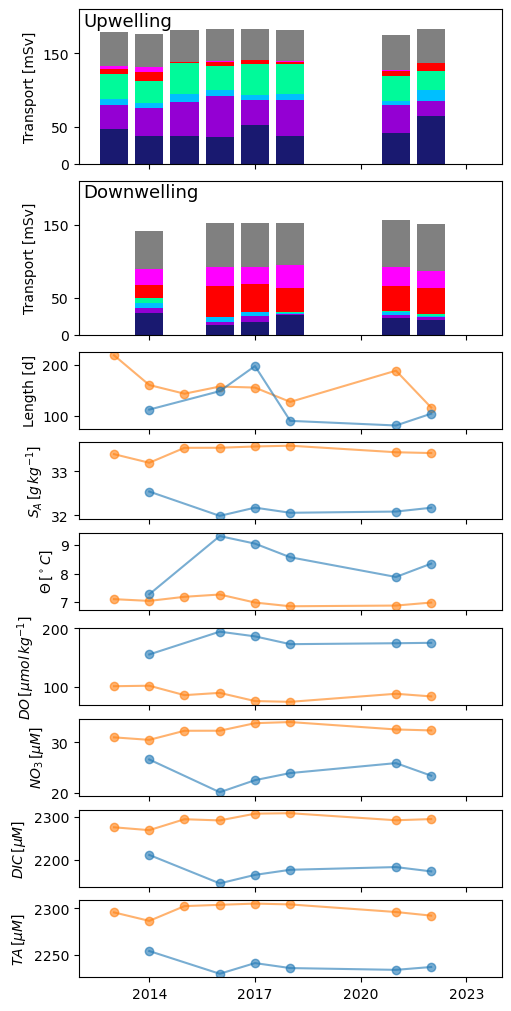

In [26]:
## maybe it makes more sense to plot interannual varriability in watermass inflow with average properties
# Assign colors to each section
colors = ['midnightblue','darkviolet','deepskyblue','mediumspringgreen','red','magenta','grey']

# fig, ax = plt.subplots(8,1,figsize=[5,3*8])
fig = plt.figure(constrained_layout=True, figsize=[5,10])
gs = GridSpec(11, 1, figure=fig)
ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[2:4,0])
axl = fig.add_subplot(gs[4, 0])
ax3 = fig.add_subplot(gs[5, 0])
ax4 = fig.add_subplot(gs[6,0])
ax5 = fig.add_subplot(gs[7, 0])
ax6 = fig.add_subplot(gs[8,0])
ax7 = fig.add_subplot(gs[9, 0])
ax8 = fig.add_subplot(gs[10,0])

#Bars of upwlling and downwelling transport from each water mass
# Plot upwelling
up_cum_values = np.zeros(len(up.columns))
for i in range(len(up)):
    bars = ax1.bar(pd.to_numeric((up.columns)), up.iloc[i,:], bottom=up_cum_values, color=colors[i % len(colors)])
    up_cum_values += up.iloc[i,:]
ax1.text(.01, 0.98, 'Upwelling', ha='left', va='top', transform=ax1.transAxes, fontsize=13)

# Plot downwelling
dw_cum_values = np.zeros(len(dw.columns))
for i in range(len(up)):
    bars = ax2.bar(pd.to_numeric((dw.columns)), dw.iloc[i,:], bottom=dw_cum_values, color=colors[i % len(colors)])
    dw_cum_values += dw.iloc[i,:]
ax2.text(.01, 0.98, 'Downwelling', ha='left', va='top', transform=ax2.transAxes, fontsize=13)

# Customize plot
for axs in [ax1,ax2]:
    axs.set_ylim(0,210000)
    axs.set_yticks([0,50000,150000])
    axs.set_yticklabels([0,50,150])
    axs.set_ylabel('Transport [mSv]')
for axs in [ax1,ax2,axl,ax3,ax4,ax5,ax6,ax7,ax8]:
    axs.set_xlim([2012,2024])
    axs.set_xticks([2014,2017,2020,2023])
for axs in [ax1,ax2,axl,ax3,ax4,ax5,ax6,ax7]:
    axs.set_xticklabels([])

# season length
axl.plot([2013,2014,2015,2016,2017,2018,2021,2022],[219, 161, 144, 158, 156,128,189, 117], alpha=0.6,c='tab:orange',marker='o')
axl.plot([2014,2016,2017,2018,2021,2022],[113, 149, 198, 91, 82, 105] , alpha=0.6,c='tab:blue',marker='o')
axl.set_ylabel('Length [d]')

# Average inflow salinity
ax3.plot([2013,2014,2015,2016,2017,2018,2021,2022],[up13.salt[0],up14.salt[0],up15.salt[0],up16.salt[0],up17.salt[0],up18.salt[0],up21.salt[0],up22.salt[0]], alpha=0.6,c='tab:orange',marker='o')
ax3.plot([2014,2016,2017,2018,2021,2022],[dw13.salt[0],dw15.salt[0],dw16.salt[0],dw17.salt[0],dw20.salt[0],dw21.salt[0]], alpha=0.6,c='tab:blue',marker='o')
ax3.set_ylabel('$S_A\, [g\, kg^{-1}]$')


# Average inflow temperature
ax4.plot([2013,2014,2015,2016,2017,2018,2021,2022],[up13.temp[0],up14.temp[0],up15.temp[0],up16.temp[0],up17.temp[0],up18.temp[0],up21.temp[0],up22.temp[0]], alpha=0.6,c='tab:orange',marker='o')
ax4.plot([2014,2016,2017,2018,2021,2022],[dw13.temp[0],dw15.temp[0],dw16.temp[0],dw17.temp[0],dw20.temp[0],dw21.temp[0]], alpha=0.6,c='tab:blue',marker='o')
ax4.set_ylabel("$\Theta\, [^\circ C]$")


# Average inflow salinity
ax5.plot([2013,2014,2015,2016,2017,2018,2021,2022],[up13.DO[0],up14.DO[0],up15.DO[0],up16.DO[0],up17.DO[0],up18.DO[0],up21.DO[0],up22.DO[0]], alpha=0.6,c='tab:orange',marker='o')
ax5.plot([2014,2016,2017,2018,2021,2022],[dw13.DO[0],dw15.DO[0],dw16.DO[0],dw17.DO[0],dw20.DO[0],dw21.DO[0]], alpha=0.6,c='tab:blue',marker='o')
ax5.set_ylabel("$DO \,[\mu mol \, kg^{-1}]$")


# Average inflow salinity
ax6.plot([2013,2014,2015,2016,2017,2018,2021,2022],[up13.NO3[0],up14.NO3[0],up15.NO3[0],up16.NO3[0],up17.NO3[0],up18.NO3[0],up21.NO3[0],up22.NO3[0]], alpha=0.6,c='tab:orange',marker='o')
ax6.plot([2014,2016,2017,2018,2021,2022],[dw13.NO3[0],dw15.NO3[0],dw16.NO3[0],dw17.NO3[0],dw20.NO3[0],dw21.NO3[0]], alpha=0.6,c='tab:blue',marker='o')
ax6.set_ylabel("$NO_3 \,[\mu M]$")


# Average inflow salinity
ax7.plot([2013,2014,2015,2016,2017,2018,2021,2022],[up13.DIC[0],up14.DIC[0],up15.DIC[0],up16.DIC[0],up17.DIC[0],up18.DIC[0],up21.DIC[0],up22.DIC[0]], alpha=0.6,c='tab:orange',marker='o')
ax7.plot([2014,2016,2017,2018,2021,2022],[dw13.DIC[0],dw15.DIC[0],dw16.DIC[0],dw17.DIC[0],dw20.DIC[0],dw21.DIC[0]], alpha=0.6,c='tab:blue',marker='o')
ax7.set_ylabel("$DIC \,[\mu M]$")


# Average inflow salinity
ax8.plot([2013,2014,2015,2016,2017,2018,2021,2022],[up13.TA[0],up14.TA[0],up15.TA[0],up16.TA[0],up17.TA[0],up18.TA[0],up21.TA[0],up22.TA[0]], alpha=0.6,c='tab:orange',marker='o')
ax8.plot([2014,2016,2017,2018,2021,2022],[dw13.TA[0],dw15.TA[0],dw16.TA[0],dw17.TA[0],dw20.TA[0],dw21.TA[0]], alpha=0.6,c='tab:blue',marker='o')
ax8.set_ylabel("$TA \,[\mu M]$")

